# Examples

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simaki/fracdiff/blob/master/sample/examples/examples.ipynb)

In [1]:
# !pip install fracdiff
# !pip install matplotlib pandas pandas_datareader seaborn statsmodels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader
import seaborn
import statsmodels.tsa.stattools as stattools
from fracdiff import Fracdiff, FracdiffStat, fdiff
from pandas.plotting import register_matplotlib_converters

In [3]:
seaborn.set_style("white")

## Coefficient

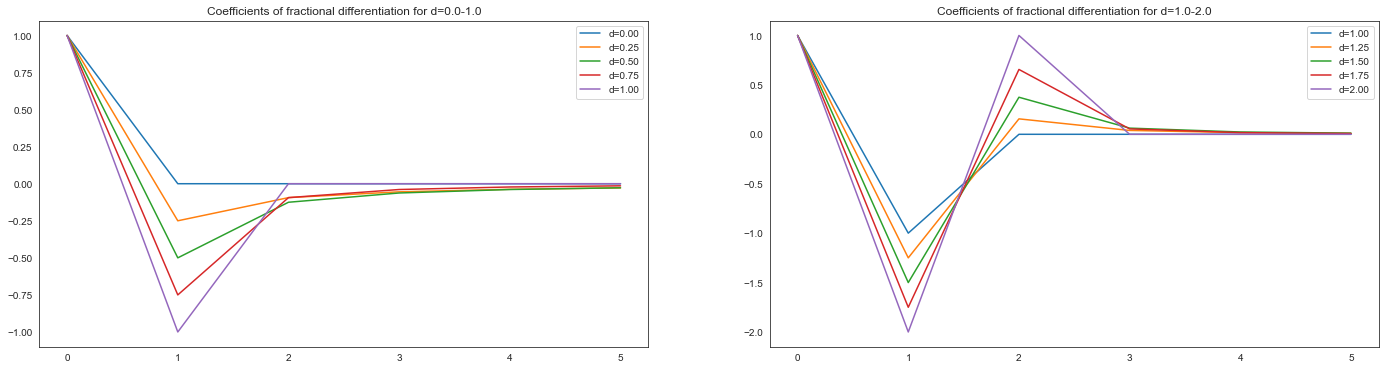

In [4]:
from fracdiff.base import fdiff_coef

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.title("Coefficients of fractional differentiation for d=0.0-1.0")
for d in np.linspace(0.0, 1.0, 5):
    plt.plot(fdiff_coef(d, 6), label=f"d={d:.2f}")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Coefficients of fractional differentiation for d=1.0-2.0")
for d in np.linspace(1.0, 2.0, 5):
    plt.plot(fdiff_coef(d, 6), label=f"d={d:.2f}")
plt.legend()

plt.show()

## S&P 500

In [5]:
def fetch_yahoo(ticker, begin="1998-01-01", end="2020-09-30"):
    """
    Returns: pandas.Series
    """
    return pandas_datareader.data.DataReader(ticker, "yahoo", begin, end)["Adj Close"]


def fetch_fred(ticker, begin="1998-01-01", end="2020-09-30"):
    """
    Returns: pandas.Series
    """
    return pandas_datareader.data.DataReader(ticker, "fred", begin, end).iloc[:, 0]

In [6]:
spx = fetch_yahoo("^GSPC")
spx.head()

Date
1997-12-31    970.429993
1998-01-02    975.039978
1998-01-05    977.070007
1998-01-06    966.580017
1998-01-07    964.000000
Name: Adj Close, dtype: float64

In [7]:
spx.shape

(5725,)

### Plotting fracdiff

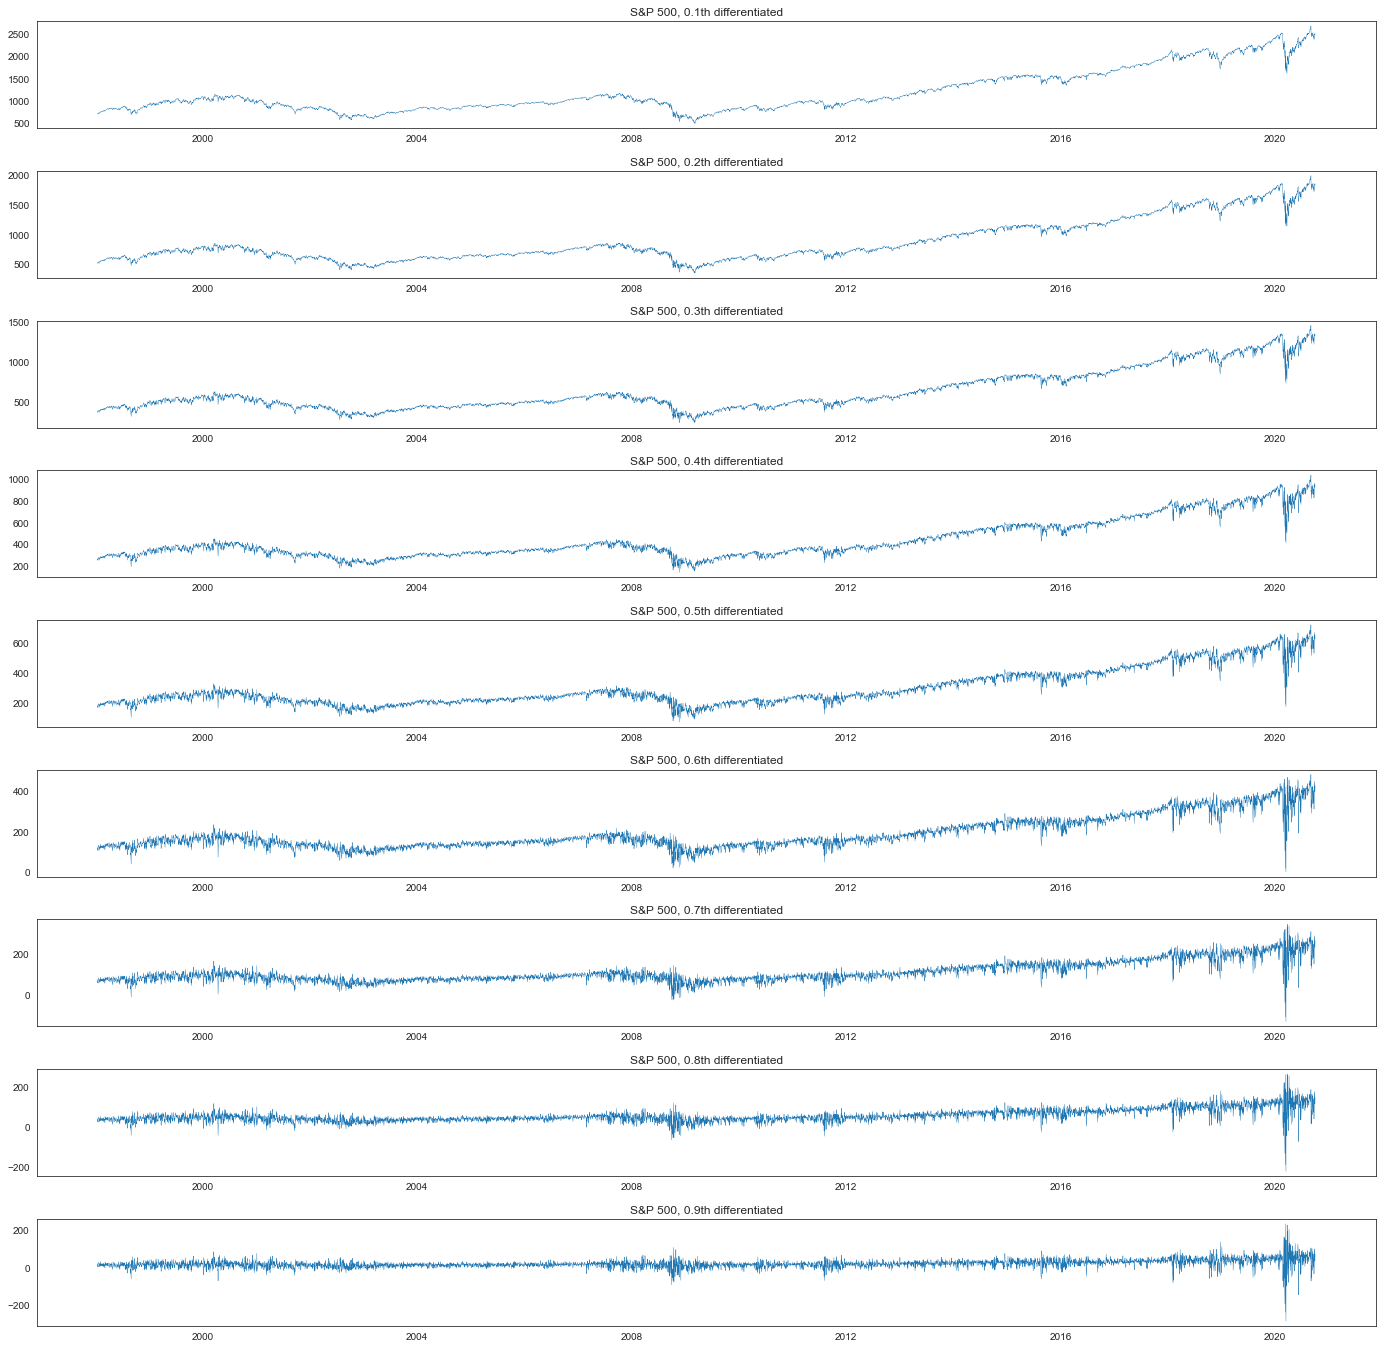

In [8]:
plt.figure(figsize=(24, 24))
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

for i, d in enumerate(np.linspace(0.1, 0.9, 9)):
    diff = fdiff(spx, d, mode="valid")
    diff = pd.Series(diff, index=spx.index[-diff.size :])
    plt.subplot(9, 1, i + 1)
    plt.title(f"S&P 500, {d:.1f}th differentiated")
    plt.plot(diff, linewidth=0.4)

plt.show()

### Stationarity of fracdiff

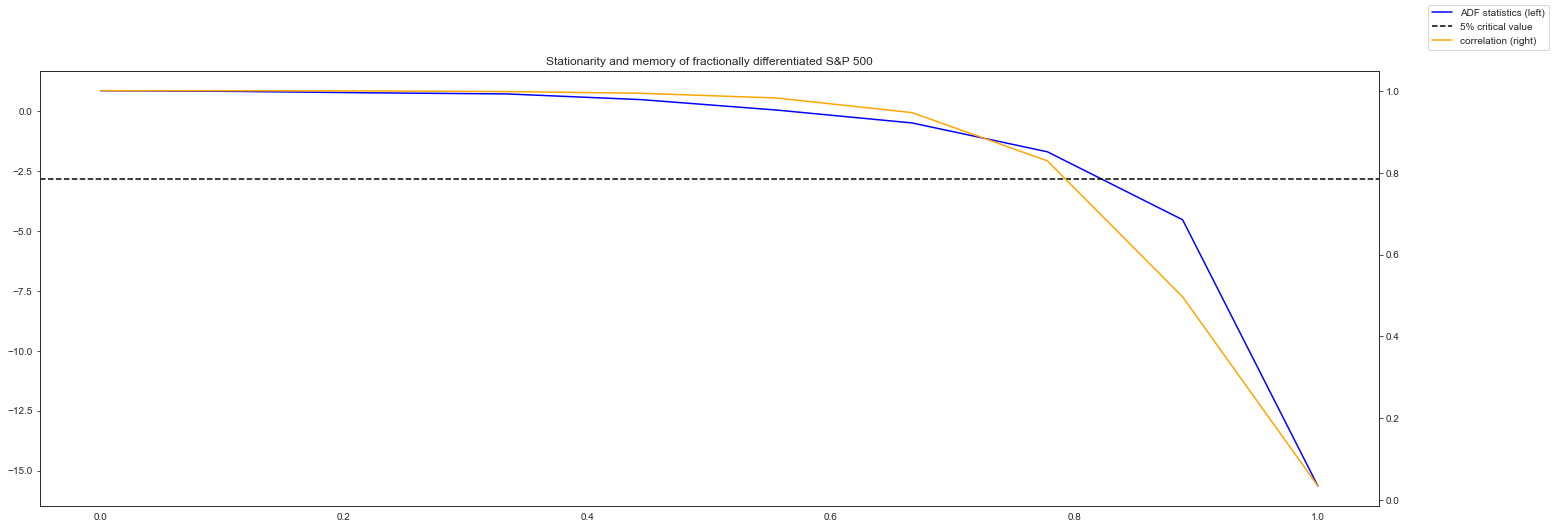

In [9]:
from fracdiff._stat import StatTester


def adfstat(d):
    diff = fdiff(spx, d, mode="valid")
    stat, *_ = stattools.adfuller(diff)
    return stat


def correlation(d):
    diff = fdiff(spx, d, mode="valid")
    corr = np.corrcoef(spx[-diff.size :], diff)[0, 1]
    return corr


ds = np.linspace(0.0, 1.0, 10)
stats = np.vectorize(adfstat)(ds)
corrs = np.vectorize(correlation)(ds)

# 5% critical value of stationarity
_, _, _, _, crit, _ = stattools.adfuller(spx)

# plot
fig, ax_stat = plt.subplots(figsize=(24, 8))
ax_corr = ax_stat.twinx()

ax_stat.plot(ds, stats, color="blue", label="ADF statistics (left)")
ax_corr.plot(ds, corrs, color="orange", label="correlation (right)")
ax_stat.axhline(y=crit["5%"], linestyle="--", color="k", label="5% critical value")

plt.title("Stationarity and memory of fractionally differentiated S&P 500")
fig.legend()
plt.show()

### Differentiation while preserving memory

In [10]:
X = spx.values.reshape(-1, 1)

fs = FracdiffStat(mode="valid")

Xdiff = fs.fit_transform(X)
_, pvalue, _, _, _, _ = stattools.adfuller(Xdiff.reshape(-1))
corr = np.corrcoef(X[-Xdiff.size :, 0], Xdiff.reshape(-1))[0][1]

print("* Order: {:.2f}".format(fs.d_[0]))
print("* ADF p-value: {:.2f} %".format(100 * pvalue))
print("* Correlation with the original time-series: {:.2f}".format(corr))

* Order: 0.84
* ADF p-value: 3.41 %
* Correlation with the original time-series: 0.66


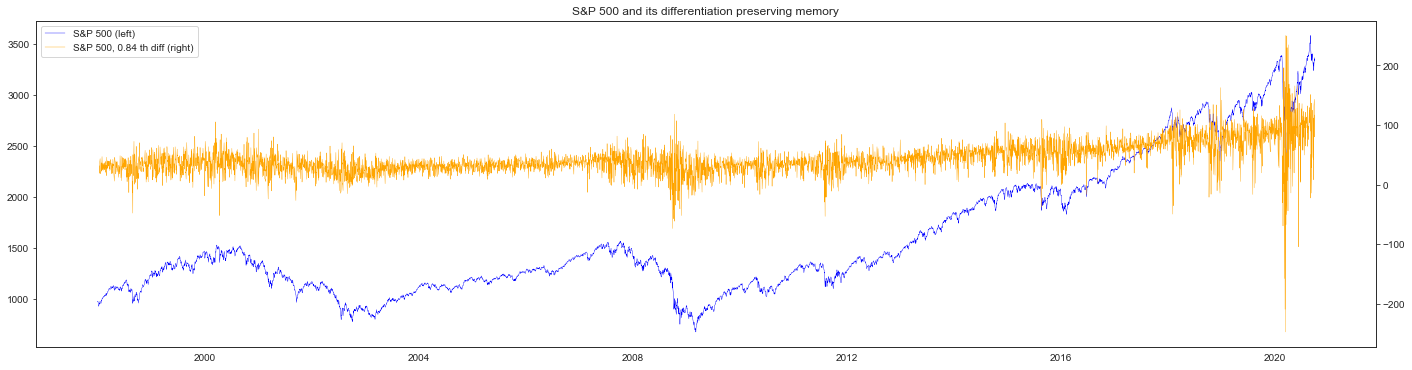

In [11]:
spx_diff = pd.Series(Xdiff.reshape(-1), index=spx.index[-Xdiff.size :])

fig, ax_s = plt.subplots(figsize=(24, 6))
plt.title("S&P 500 and its differentiation preserving memory")
ax_d = ax_s.twinx()

plot_s = ax_s.plot(spx, color="blue", linewidth=0.4, label="S&P 500 (left)")
plot_d = ax_d.plot(
    spx_diff,
    color="orange",
    linewidth=0.4,
    label=f"S&P 500, {fs.d_[0]:.2f} th diff (right)",
)
plots = plot_s + plot_d

ax_s.legend(plots, [p.get_label() for p in plots], loc=0)
plt.show()

### Other financial data

In [12]:
nt_yahoo = [
    ("S&P 500", "^GSPC"),
    ("Nikkei 225", "^N225"),
    ("Shanghai Comp", "^SSEC"),
    ("US 10y", "^TNX"),
    ("Apple", "AAPL"),
]
nt_fred = [
    ("USD/JPY", "DEXJPUS"),
    ("Gold", "GOLDPMGBD228NLBM"),
    ("Crude Oil", "DCOILWTICO"),
]

dfy = pd.DataFrame({name: fetch_yahoo(ticker) for name, ticker in nt_yahoo})
dff = pd.DataFrame({name: fetch_fred(ticker) for name, ticker in nt_fred})

prices = pd.concat([dfy, dff], axis=1).fillna(method="ffill").loc["1998-01-05":]

In [13]:
prices

,S&P 500,Nikkei 225,Shanghai Comp,US 10y,Apple,USD/JPY,Gold,Crude Oil
1998-01-05,977.070007,14956.839844,1220.473022,5.498,0.122484,133.99,284.40,16.95
1998-01-06,966.580017,14896.400391,1233.619995,5.473,0.146113,133.88,282.80,16.64
1998-01-07,964.000000,15028.169922,1244.069946,5.527,0.135022,131.70,281.60,16.91
1998-01-08,956.049988,15019.179688,1237.162964,5.465,0.140326,132.49,281.65,17.01
1998-01-09,927.690002,14995.099609,1239.901001,5.379,0.140326,131.52,278.70,16.65
...,...,...,...,...,...,...,...,...
2020-09-24,3246.590088,23087.820312,3331.521973,0.666,108.220001,105.42,1861.75,40.11
2020-09-25,3298.459961,23204.619141,3331.521973,0.659,112.279999,105.59,1859.70,40.06
2020-09-28,3351.600098,23511.619141,3331.521973,0.663,114.959999,105.50,1864.30,40.47
2020-09-29,3335.469971,23539.099609,3331.521973,0.645,114.089996,105.68,1883.95,39.03


In [14]:
def stats(X):
    return [stattools.adfuller(X[:, i])[0] for i in range(X.shape[1])]


ds = np.linspace(0.0, 1.0, 11)

df_stats = pd.DataFrame(
    [stats(Fracdiff(d, mode="valid").fit_transform(prices.values)) for d in ds],
    index=ds,
    columns=prices.columns,
)

df_stats

,S&P 500,Nikkei 225,Shanghai Comp,US 10y,Apple,USD/JPY,Gold,Crude Oil
0.0,0.968324,-1.170435,-2.116867,-1.153880,4.951773,-2.178117,0.049131,-2.434859
0.1,0.921352,-1.159694,-2.157641,-1.191706,4.862630,-2.132538,0.028313,-2.412764
0.2,0.802339,-1.311269,-2.128508,-1.240243,4.745854,-2.145354,-0.028585,-2.369947
0.3,0.717212,-1.359395,-2.250318,-1.268093,4.592151,-2.120619,-0.055576,-2.324401
0.4,0.565597,-1.313894,-2.257933,-1.430662,4.374133,-2.204098,-0.117716,-2.297110
0.5,0.290000,-1.587270,-2.328407,-1.673761,4.006742,-2.392610,-0.172077,-2.330552
0.6,-0.022086,-1.551456,-2.549346,-1.959220,3.325249,-2.481928,-0.410898,-2.502265
0.7,-0.728352,-2.142965,-2.883885,-2.162136,2.125019,-3.043593,-0.847778,-2.952382
0.8,-1.865212,-3.419540,-4.061263,-3.273391,0.207860,-4.235373,-1.633992,-4.159692
0.9,-4.699825,-6.702866,-7.249331,-6.317477,-3.184654,-7.890231,-3.769678,-7.355233


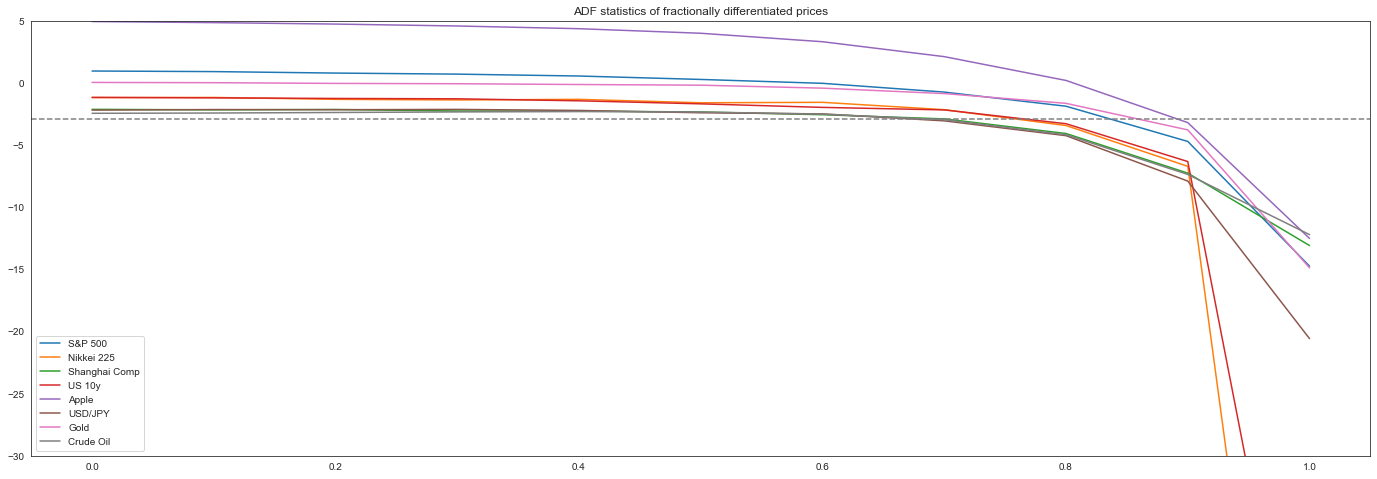

In [15]:
_, _, _, _, crit, _ = stattools.adfuller(prices["S&P 500"].values)

df_stats.plot(figsize=(24, 8), ylim=(-30, 5))
plt.axhline(y=crit["5%"], linestyle="--", color="gray")
plt.title("ADF statistics of fractionally differentiated prices")
plt.show()